# Preliminary info:
- Data comes pre-split into train test, however the test set only contains one instance of each class
- There are 29 subdirectories in the train set, 3 of which are nonalpha 
- We'll also disregard J and Z since they require movement to sign
- Train set: 87,000 images which are 200x200 pixels
- Test set: 29 images same reso
- Need to think about having an 'other' class

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

RANDOM_SEED = 21223

In [38]:
from zipfile import ZipFile
dir_path = "../data"
train_path = dir_path + "/asl_train"
test_path = dir_path + "/asl_test"

def unzip_if_not_exists(zip_file_path, extract_to_path):
    # check if the target directory already exists
    if not os.path.exists(extract_to_path):
        # create the directory if it doesn't exist
        os.makedirs(extract_to_path)
        # unzip the contents
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully unzipped to {extract_to_path}")
    else:
        print(f"The directory {extract_to_path} already exists. Skipped unzipping.")

unzip_if_not_exists(dir_path + "/asl_alphabet_train.zip", train_path)
unzip_if_not_exists(dir_path + "/asl_alphabet_test.zip", test_path)

The directory ../data/asl_train already exists. Skipped unzipping.
The directory ../data/asl_test already exists. Skipped unzipping.


In [39]:
train_path += "/asl_alphabet_train/"
test_path += "/asl_alphabet_test/"

# map alphabet to numbers
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "K",
                10: "L",
                11: "M",
                12: "N",
                13: "O",
                14: "P",
                15: "Q",
                16: "R",
                17: "S",
                18: "T",
                19: "U",
                20: "V",
                21: "W",
                22: "X",
                23: "Y",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df

# store all the file names in the dataset
filenames = []
# store the corresponding class for each file
target = []

for category in categories:
    files = os.listdir(train_path + categories[category])
    filenames += files
    target += [category] * len(files)

df = pd.DataFrame({"filename": filenames, "category": target})
df = add_class_name_prefix(df, "filename")

# shuffle the dataframe
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [40]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  72000 non-null  object
 1   category  72000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,filename,category
0,V1957.jpg,20
1,M2695.jpg,11
2,C705.jpg,2
3,T1148.jpg,18
4,P600.jpg,14


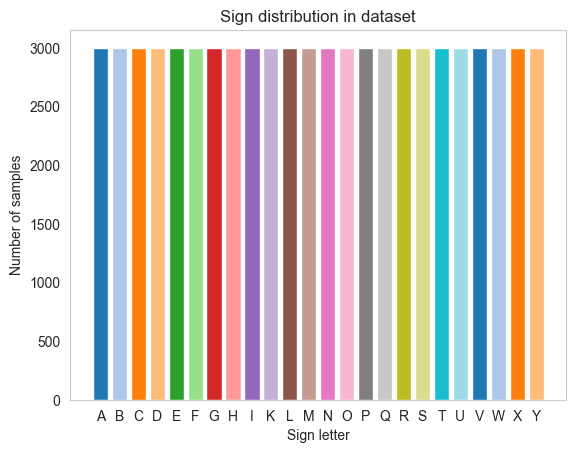

In [41]:
# plot class distribution
unique_labels, counts = np.unique(df['category'], return_counts=True)

cmap = plt.get_cmap("tab20")

plt.bar(list(categories.values()), counts, color=cmap.colors)
plt.xlabel('Sign letter')
plt.ylabel('Number of samples')
plt.title('Sign distribution in dataset')
plt.grid(False)
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

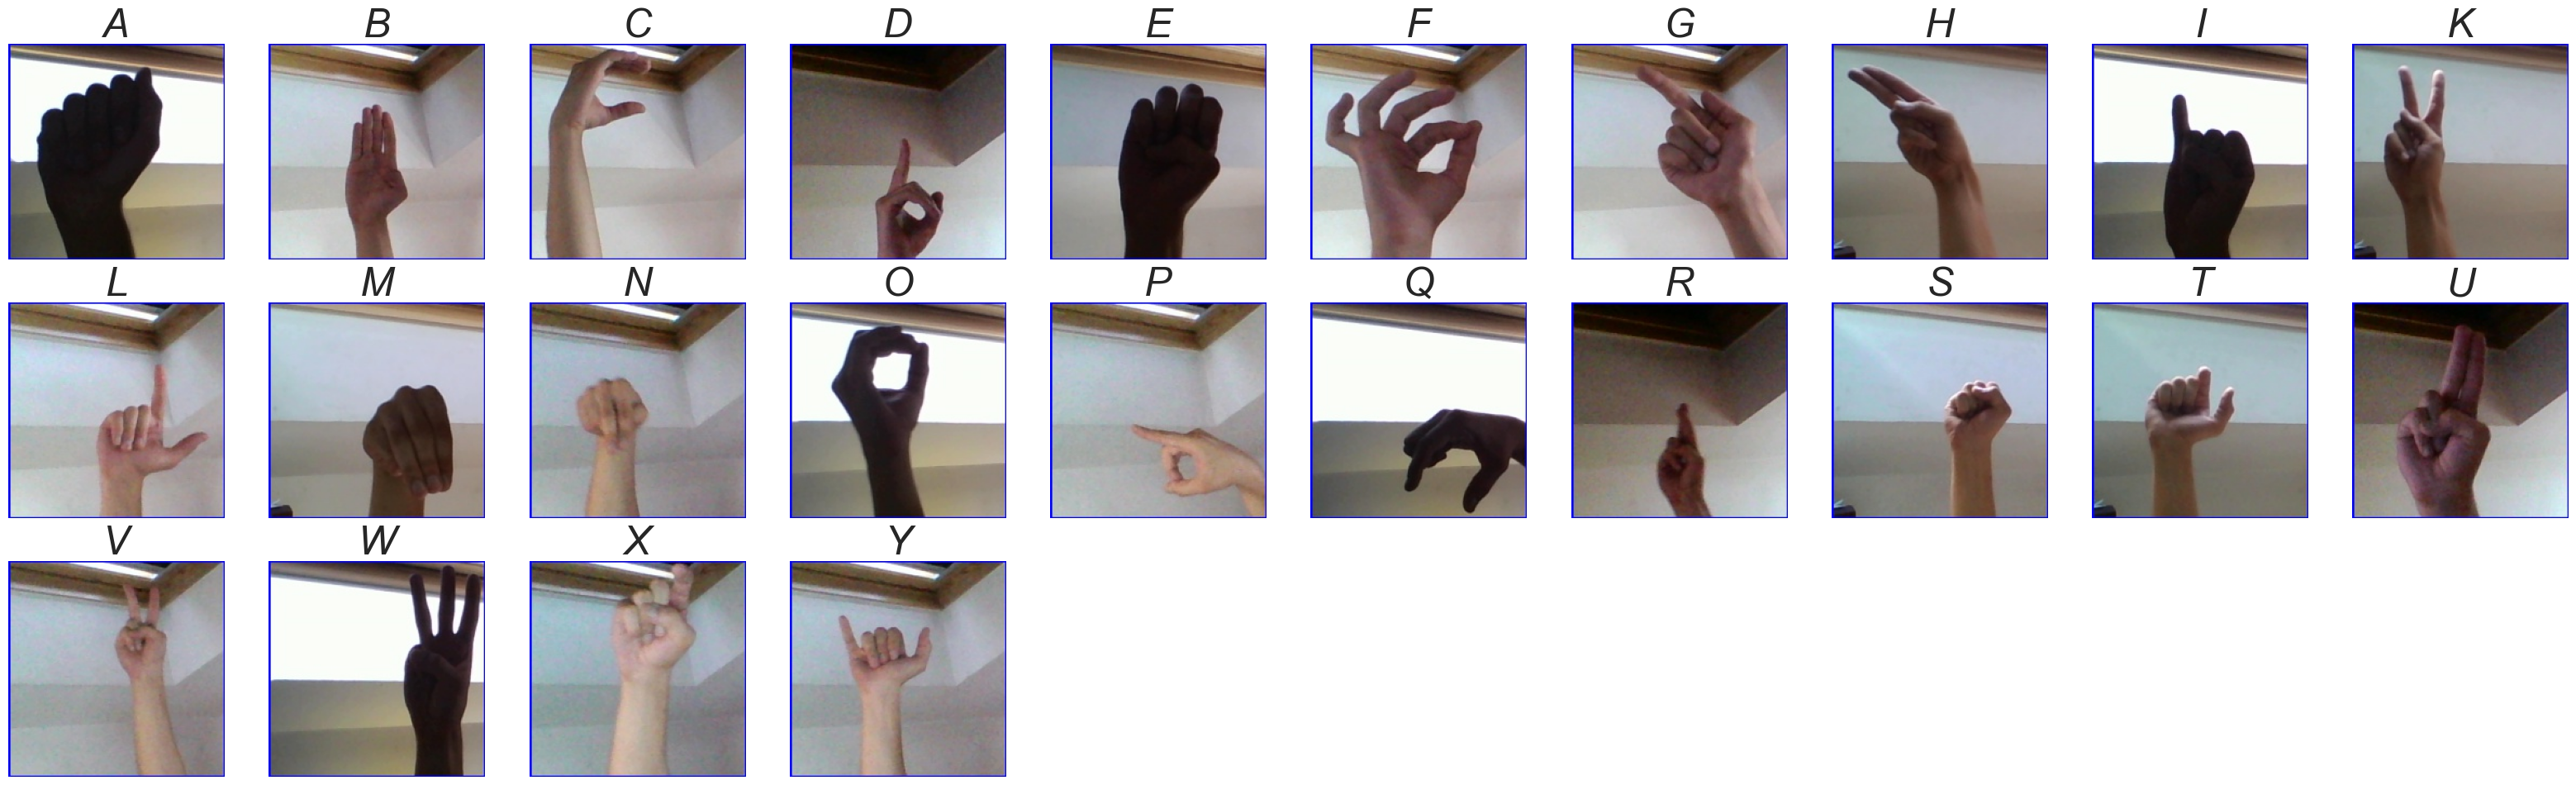

In [42]:
# plot a few example images

plt.figure(figsize=(40,40))

for i in range(25):
    img_names = df.loc[df["category"]==i]
    img_name = img_names.sample(1, ignore_index=True, random_state=RANDOM_SEED).filename[0]
    path = ""
    path = train_path + categories[i] + "/" + img_name
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[i],fontsize=35,fontstyle='italic')
    plt.axis("off")

# Attempting some low dim visualization

In [ ]:
# i could not get cv2 to work in pipenv
#import cv2
#
# image to numbers
#def process_row(row):
#    filename = row["filename"]
#    label = row["category"]
#    # load
#    image = cv2.imread(train_path + "/" + categories[label] + "/" + filename)
#    # convert to grayscale
#    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    # flatten 2d tensor to 1d array
#    flat_image = gray_image.ravel()
#    
#    new_row = pd.DataFrame({'image_array': [flat_image], 'label': label})
#    return new_row
#
#df.apply(process_row, axis=1, result_type="expand")

In [43]:
from PIL import Image

# image to numbers
def process_row(row):
    filename = row["filename"]
    label = row["category"]
    # load
    image = Image.open(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = image.convert('L')
    # convert to 2d tensor
    image_array = np.array(gray_image)
    # flatten 2d tensor to 1d array
    flat_image = image_array.ravel()
    new_row = {'image_array': flat_image, 'label': label}
    return new_row

# sample 50 random data points from each sign
small_df = df.groupby('category', group_keys=False).apply(lambda x: x.sample(50, ignore_index=True, random_state=RANDOM_SEED))
# shuffle
small_df = small_df.sample(frac=1).reset_index(drop=True)
# turn each image into a 1d numerical array
result_df = small_df.apply(process_row, axis=1, result_type="expand")

In [44]:
result_df.head()

,image_array,label
0,"[30, 33, 27, 31, 29, 28, 32, 28, 30, 29, 29, 2...",21
1,"[31, 32, 28, 29, 31, 30, 29, 30, 30, 30, 29, 3...",23
2,"[32, 31, 28, 29, 29, 30, 31, 29, 29, 30, 29, 2...",13
3,"[34, 30, 30, 31, 30, 29, 29, 28, 28, 29, 30, 3...",4
4,"[32, 34, 27, 32, 29, 29, 30, 29, 29, 28, 30, 3...",23


In [45]:
# convert 'image_array' to separate columns
image_columns = pd.DataFrame(result_df['image_array'].apply(pd.Series).values, columns=[f'pixel_{i}' for i in range(len(result_df['image_array'].iloc[0]))])

image_columns.head()
image_columns.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_39990,pixel_39991,pixel_39992,pixel_39993,pixel_39994,pixel_39995,pixel_39996,pixel_39997,pixel_39998,pixel_39999
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000
mean,30.496667,31.121667,29.165000,29.836667,29.384167,29.698333,28.789167,29.529167,29.305000,29.205833,...,28.955833,28.923333,28.730833,29.156667,28.769167,28.793333,29.26750,28.793333,28.857500,29.200833
std,1.294109,1.669587,1.197485,1.147935,1.109478,1.192413,1.210759,0.991616,0.756606,0.728406,...,0.528314,0.683992,1.169554,1.741067,1.405654,1.508593,1.35615,1.440724,1.780872,1.193043
min,28.000000,28.000000,27.000000,27.000000,27.000000,27.000000,26.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,24.000000,24.000000,24.000000,24.000000,24.00000,23.000000,24.000000,26.000000
25%,30.000000,30.000000,28.000000,29.000000,29.000000,29.000000,28.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,28.000000,28.000000,28.000000,28.000000,28.00000,28.000000,28.000000,28.000000
50%,30.000000,31.000000,29.000000,30.000000,29.000000,30.000000,29.000000,29.500000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.00000,29.000000,29.000000,29.000000
75%,31.000000,32.000000,30.000000,31.000000,30.000000,30.000000,29.000000,30.000000,30.000000,30.000000,...,29.000000,29.000000,29.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000
max,35.000000,36.000000,34.000000,34.000000,33.000000,34.000000,34.000000,33.000000,32.000000,33.000000,...,32.000000,33.000000,33.000000,35.000000,33.000000,32.000000,34.00000,33.000000,36.000000,33.000000


In [46]:
x = np.array(image_columns.values)
print(x)

# scale pixel values to [0,1]
x_scaled = x / np.max(np.max(x))

scaled_df = pd.DataFrame(x_scaled)
scaled_df['label'] = result_df['label']

scaled_df.describe()
scaled_df.head(2)

[[30 33 27 ... 28 28 30]
 [31 32 28 ... 30 30 27]
 [32 31 28 ... 29 31 29]
 ...
 [33 29 31 ... 29 30 27]
 [31 30 30 ... 28 27 31]
 [31 32 29 ... 26 30 29]]


,0,1,2,3,4,5,6,7,8,9,...,39991,39992,39993,39994,39995,39996,39997,39998,39999,label
0,0.117647,0.129412,0.105882,0.121569,0.113725,0.109804,0.125490,0.109804,0.117647,0.113725,...,0.113725,0.105882,0.121569,0.109804,0.121569,0.109804,0.109804,0.109804,0.117647,21
1,0.121569,0.125490,0.109804,0.113725,0.121569,0.117647,0.113725,0.117647,0.117647,0.117647,...,0.121569,0.121569,0.098039,0.125490,0.117647,0.105882,0.117647,0.117647,0.105882,23


# PCA
The main idea of PCA is to transform the high dimensional input space onto the feature space with maximal variance. 

In [47]:
from sklearn.decomposition import PCA
import seaborn as sns

pixels = scaled_df.drop('label', axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pixels)

pca_df = pd.DataFrame() 
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['label'] = scaled_df['label']

pca_df.head()

,pca-one,pca-two,label
0,-0.260032,-19.076408,21
1,17.797616,4.680536,23
2,-1.462966,-19.800044,13
3,-1.123095,12.889411,4
4,-1.445005,-21.577593,23


/var/folders/x1/dl1z_tcs7zb6pppfbf65d5sh0000gn/T/ipykernel_63416/4168278994.py:5: UserWarning: The palette list has more values (25) than needed (24), which may not be intended.
  ax = sns.scatterplot(


AttributeError: 'Axes' object has no attribute 'add_legend'

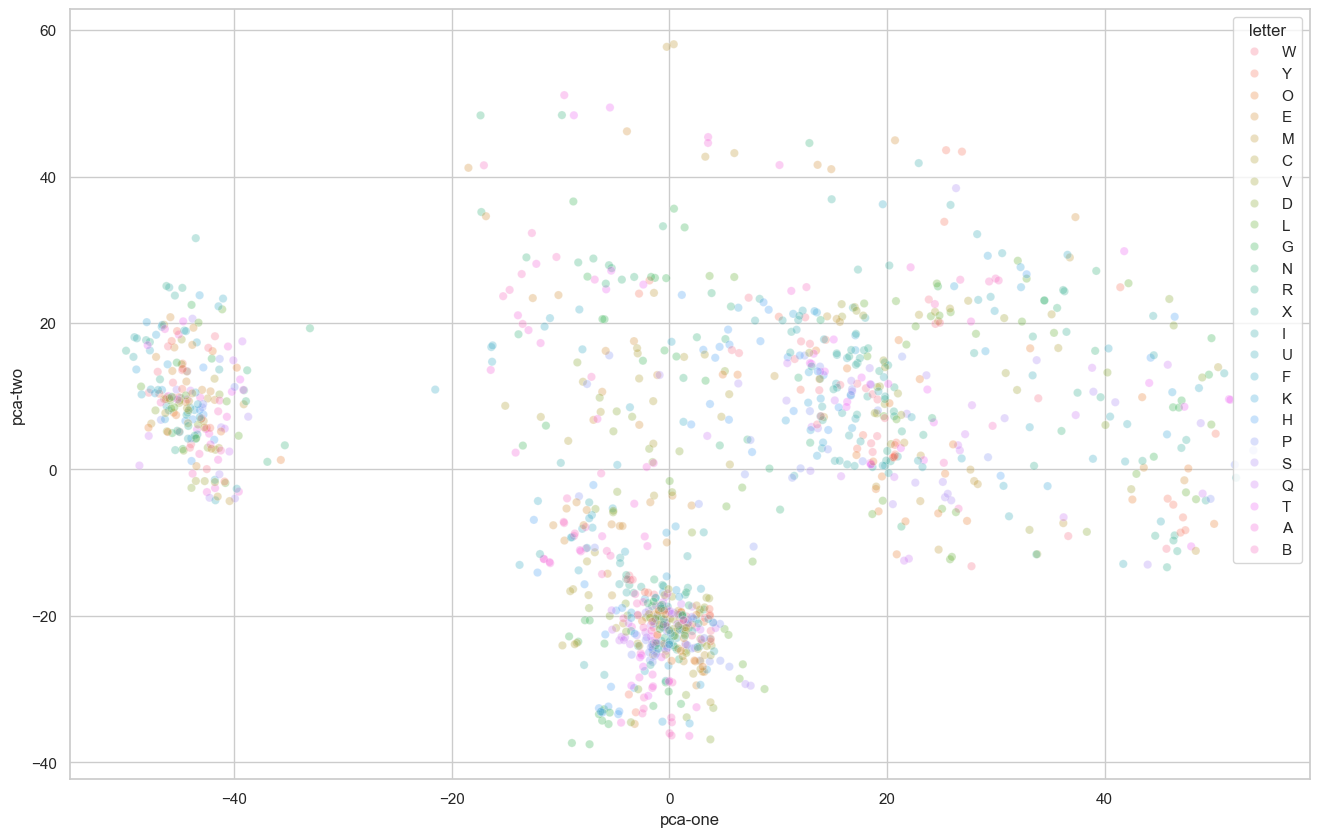

In [51]:
pca_df['letter'] = pca_df['label'].apply(lambda x: categories[x])

sns.set(style="whitegrid")
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="letter",
    palette=sns.color_palette("husl", 25),
    data=pca_df,
    legend="full",
    alpha=0.3
)
ax.add_legend(label_order = sorted(ax._legend_data.keys()))
plt.title('PCA feature space of ASL alphabet', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Sign Letter')

In [ ]:
from sklearn.manifold import TSNE

pixels = scaled_df.drop('label', axis=1)

pca = PCA(n_components=1000)
pca_result = pca.fit_transform(pixels)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(pca_result)
tsne.kl_divergence_

In [ ]:
tsne_df = pd.DataFrame(data=X_tsne, columns=['tsne_1', 'tsne_2'])
tsne_df['label'] = scaled_df['label']
tsne_df['letter'] = tsne_df['label'].apply(lambda lbl : categories[lbl])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='tsne_1', 
    y='tsne_2', 
    hue='letter', 
    data=tsne_df, 
    palette=sns.color_palette("husl", 25)
)

# Set plot title and labels
plt.title('t-SNE Visualization after PCA', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Show legend
plt.legend(title='Sign Letter')

# Show the plot
plt.show()